In [10]:
import glob
import io
import itertools
import numpy as np
import os
import pandas as pd
import re
from IPython.display import clear_output, display
from ipyevents import Event
from ipywidgets import FloatSlider, Image, IntSlider, Layout, fixed, interact, widgets
from itertools import chain
from matplotlib.widgets import Button
from pathlib import Path
from PIL import Image as PILImage
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Constants
MAX_TIF_VALUE = 2**16 - 1  # Max value for a 16-bit image
BACKGROUND_THRESHOLD = 0.015  # Threshold for background detection
SATURATION_THRESHOLD = 0.99  # Threshold for saturation detection
IMAGE_FORMATS = ["*.Tif", "*.tif", "*.TIF", "*.tiff", "*.TIFF"]  # Standardized format list TODO: Check if always TIFF
FOLDER_PATH = "/Users/josec/JC/spaik/western-blot/data/wb/Datos WB 10 jul 2017"  # Specify your folder path
OPTIONS_1 = ["Membrane 1", "Membrane 2"]
OPTIONS_2 = ["Lane 1", "Lane 2", "Lane 3", "Lane 4", "Lane 5", "Lane 6", "Lane 7", "Lane 8", "Lane 9", "Lane 10"]
OPTIONS_3 = ["FH", "FHR5", "FHL1+FHR1beta", "FHR1alfa", "FHR4A", "FHR4B + FHR3"]

In [8]:
# Utils
def extract_exposure_time(file_path: str, pattern: str = r"(\d+)") -> float:
    file_name = Path(file_path).name  # Extract the file name from the path
    match = re.search(pattern, file_name)  # Search for the pattern
    if match:
        return float(match.group(1))  # Convert the first group to float
    else:
        raise ValueError(f"No exposure time found in {file_name}")


def load_and_process_images(folder_path: str, image_formats: list = IMAGE_FORMATS) -> tuple:
    folder = Path(folder_path)
    # Gather all files matching the image format patterns
    files = sorted(chain(*(folder.glob(pattern) for pattern in image_formats)))

    if not files:
        print("No images found in the specified folder.")
        return None, None

    # Load, convert to float for processing, and invert images
    images = [np.array(PILImage.open(file)).astype(float) for file in files]
    images = [MAX_TIF_VALUE - image for image in images]
    # Sort images by their total intensity (sum of pixel values)
    images = sorted(images, key=lambda img: np.sum(img))
    # Stack images and normalize the pixel values
    images_stack = np.stack([np.zeros_like(images[0])] + images, axis=-1) / MAX_TIF_VALUE

    # Extract exposure times for all images
    exposure_times = [extract_exposure_time(file) for file in files]
    # Prepend a zero for exposure times to match image stack structure
    exposure_times = np.array([0] + exposure_times)

    print(f"Found {len(files)} files.")
    print(f"Images shape: {images_stack.shape} (added a zero image as the first channel)")
    print(f"Exposure times: {exposure_times}")
    return images_stack, exposure_times


def get_background_mean_noise(images_stack: np.ndarray, threshold: float) -> np.ndarray:
    # Mask the foreground based on the threshold
    background_mask = np.mean(images_stack, axis=-1) < threshold
    # Calculate the mean background noise for each exposure time
    mean_noise = np.mean(images_stack[background_mask], axis=0)
    return background_mask, mean_noise


def extract_intensities(images_stack: np.ndarray, 
                       exposure_times: np.ndarray, 
                       mean_noise: np.ndarray) -> np.ndarray:
    # Check if images_stack is below the saturation threshold 
    valid_mask = images_stack < SATURATION_THRESHOLD

    # Subtract mean noise from the images (background correction for intensity linearity)
    images_stack_denoised = images_stack - mean_noise

    # Apply mask to images, place NaN where mask is False
    filtered_values = np.where(valid_mask, images_stack_denoised, np.nan)

    # Apply mask to exposure times, place NaN where mask is False
    filtered_exposure_times = np.where(valid_mask, exposure_times, np.nan)

    # Calculate intensities (slope of the linear regression) with least squares method
    numerator = np.nansum(filtered_exposure_times * filtered_values, axis=-1)
    denominator = np.nansum(filtered_exposure_times**2, axis=-1)
    intensities = numerator / denominator

    # Normalize the image
    intensities /= np.nanmax(intensities)  # Normalize by the maximum value
    intensities = np.clip(intensities, 0, 1)  # Clip values between 0 and 1
    intensities = np.nan_to_num(intensities, nan=1.0)  # Replace NaNs with 1.0

    return intensities

In [4]:
# Interactive plotting
def plot_image_at_time(index: int, images_stack: np.ndarray, exposure_times: np.ndarray):
    plt.close()
    plt.figure(figsize=(10, 6))
    plt.imshow(1 - images_stack[:, :, index], cmap='gray', vmin=0, vmax=1)
    plt.title(f"Exposure Time: {exposure_times[index]} seconds")
    cbar = plt.colorbar()
    cbar.ax.invert_yaxis()
    cbar.set_label('Intensity')
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    cbar.set_ticklabels(['100%', '75%', '50%', '25%', '0%'])
    plt.show()


def plot_mean_noise(threshold: float, images_stack: np.ndarray, exposure_times: np.ndarray) -> None:
    global current_threshold
    current_threshold = threshold
    background_mask, mean_noise = get_background_mean_noise(images_stack, threshold)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(exposure_times, mean_noise, marker='o', linestyle='--', label='Noise values')
    plt.ylim(0, 0.05)
    plt.title("Mean Noise Over Exposure Times")
    plt.xlabel("Exposure Time (s)")
    plt.ylabel("Mean Noise")
    plt.grid(True)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.imshow((1 - background_mask.astype(float)) * (1 - images_stack[:, :, -1]), cmap='gray', vmin=0, vmax=1)
    plt.title("Background Mask")
    plt.tight_layout()
    plt.show()


def plot_image_and_pixel_values(images_stack: np.ndarray, exposure_times: np.ndarray, mean_noise: np.ndarray, n_test_points: int):
    # Randomly select n_test_points indices within the image dimensions
    i = np.random.randint(0, images_stack.shape[0], n_test_points)  # Random row indices
    j = np.random.randint(0, images_stack.shape[1], n_test_points)  # Random column indices
    
    # Initialize the figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Top-left subplot: Image with scatter points
    im_ax = axes[0, 0]
    im = im_ax.imshow(1 - images_stack[..., 5], cmap='gray', aspect='auto')
    colors = []  # To store colors for later use
    for idx in range(n_test_points):
        scatter = im_ax.scatter(j[idx], i[idx], s=50, label=f'Pixel {idx}')
        colors.append(scatter.get_facecolor()[0])  # Extract color from scatter
    # horizontal legend
    im_ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), ncol=5)
    im_ax.set_title('Image with Selected Pixels')

    # Top-right subplot: Mean noise plot
    axes[0, 1].plot(exposure_times, mean_noise, marker='o', linestyle='-', color='tab:red')
    axes[0, 1].set_title('Mean Noise across Exposure Times')
    axes[0, 1].set_xlabel('Exposure Time (s)')
    axes[0, 1].set_ylabel('Noise Level')
    axes[0, 1].grid(True)

    # Bottom-left subplot: Pixel values over exposure times
    for idx in range(n_test_points):
        axes[1, 0].plot(exposure_times, images_stack[i[idx], j[idx], :].T, marker='o', linestyle='--', color=colors[idx], label=f'Pixel {idx}')
    axes[1, 0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), ncol=2)
    axes[1, 0].set_title('Pixel Values over Exposure Times (non-linear)')
    axes[1, 0].set_xlabel('Exposure Time (s)')
    axes[1, 0].set_ylabel('Pixel Value')
    axes[1, 0].grid(True)

    # Bottom-right subplot: Pixel values minus mean noise
    for idx in range(n_test_points):
        line_no_noise = images_stack[i[idx], j[idx], :] - mean_noise  # Subtracting mean noise from pixel values
        axes[1, 1].plot(exposure_times, line_no_noise, marker='o', linestyle='--', color=colors[idx], label=f'Pixel {idx}')
    axes[1, 1].legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), ncol=2)
    axes[1, 1].set_title('Pixel Values minus Mean Noise (linear)')
    axes[1, 1].set_xlabel('Exposure Time (s)')
    axes[1, 1].set_ylabel('Pixel Value')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


def plot_intensities(idx: int, intensities: np.ndarray):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Create two subplots horizontally

    # Plot for the intensity image with a vertical line
    axs[0].imshow(1 - intensities, cmap='gray')
    axs[0].vlines(idx, 150, 500, color='red', linestyle='--')
    axs[0].set_title("Intensity Image")

    # Plot for pixel values along the selected column
    axs[1].plot(intensities[150:500, idx], color='red', linestyle='--')
    axs[1].set_ylim(0, 1)
    axs[1].set_title("Pixel Values over Exposure Times")
    axs[1].set_xlabel("Position along column")
    axs[1].set_ylabel("Pixel Value")

    plt.tight_layout()
    plt.show()


In [11]:
# Load and visualize images
images_stack, exposure_times = load_and_process_images(FOLDER_PATH)
_ = interact(plot_image_at_time, 
         index=IntSlider(min=0, max=len(exposure_times)-1, step=1, value=0), 
         images_stack=fixed(images_stack), 
         exposure_times=fixed(exposure_times))

/Users/josec/Dive/total-energies/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Found 10 files.
Images shape: (600, 800, 11) (added a zero image as the first channel)
Exposure times: [  0.  10.  30.  60. 120. 180. 240. 300. 360. 420. 480.]


interactive(children=(IntSlider(value=0, description='index', max=10), Output()), _dom_classes=('widget-intera…

### Linear Estimation of Pixel Intensities Across Time Exposures with Background Noise Correction
In this analysis, we examine the relationship between pixel values and varying exposure times in an image. When plotting these values, we observe a general linear increase with time. However, there are noticeable nonlinearities such as the lack of a zero intercept of the linear trend (intensity should be zero at zero time) and areas where the response saturates, causing the trend line to flatten because it cannot increase further.

![Nonlinearities](figure_0.png)

These nonlinearities are primarily caused by additive background noise in the image. By selecting random points across the image and adjusting these values by subtracting the mean, the resulting trend consistently appears linear. This suggests the presence of an additive component, i.e., the average background noise.

![Pixel Differences](figure_1.png)

To accurately estimate this background noise, we employ a mask to isolate pixels where there is no expected signal. From these selected pixels, we can calculate the average value. By subtracting this mean value from the entire image, we rectify the trend to a linear relationship for all pixels.

To further refine our analysis, we remove saturation points (where the signal is flat) and apply a linear regression through the origin using the least squares method. This approach allows us to estimate the true emission intensity values of the pixels based on the slope of the linear trend with respect to exposure time.

This method effectively adjusts for non-linearities and provides a robust estimate of the true pixel intensities in the image.



In [12]:
threshold_slider = FloatSlider(value=0.015, min=0.001, max=0.05, step=0.001, description='Background Threshold:', readout_format='.3f')
interact(plot_mean_noise, threshold=threshold_slider, images_stack=fixed(images_stack), exposure_times=fixed(exposure_times))

interactive(children=(FloatSlider(value=0.015, description='Background Threshold:', max=0.05, min=0.001, reado…

<function __main__.plot_mean_noise(threshold: float, images_stack: numpy.ndarray, exposure_times: numpy.ndarray) -> None>

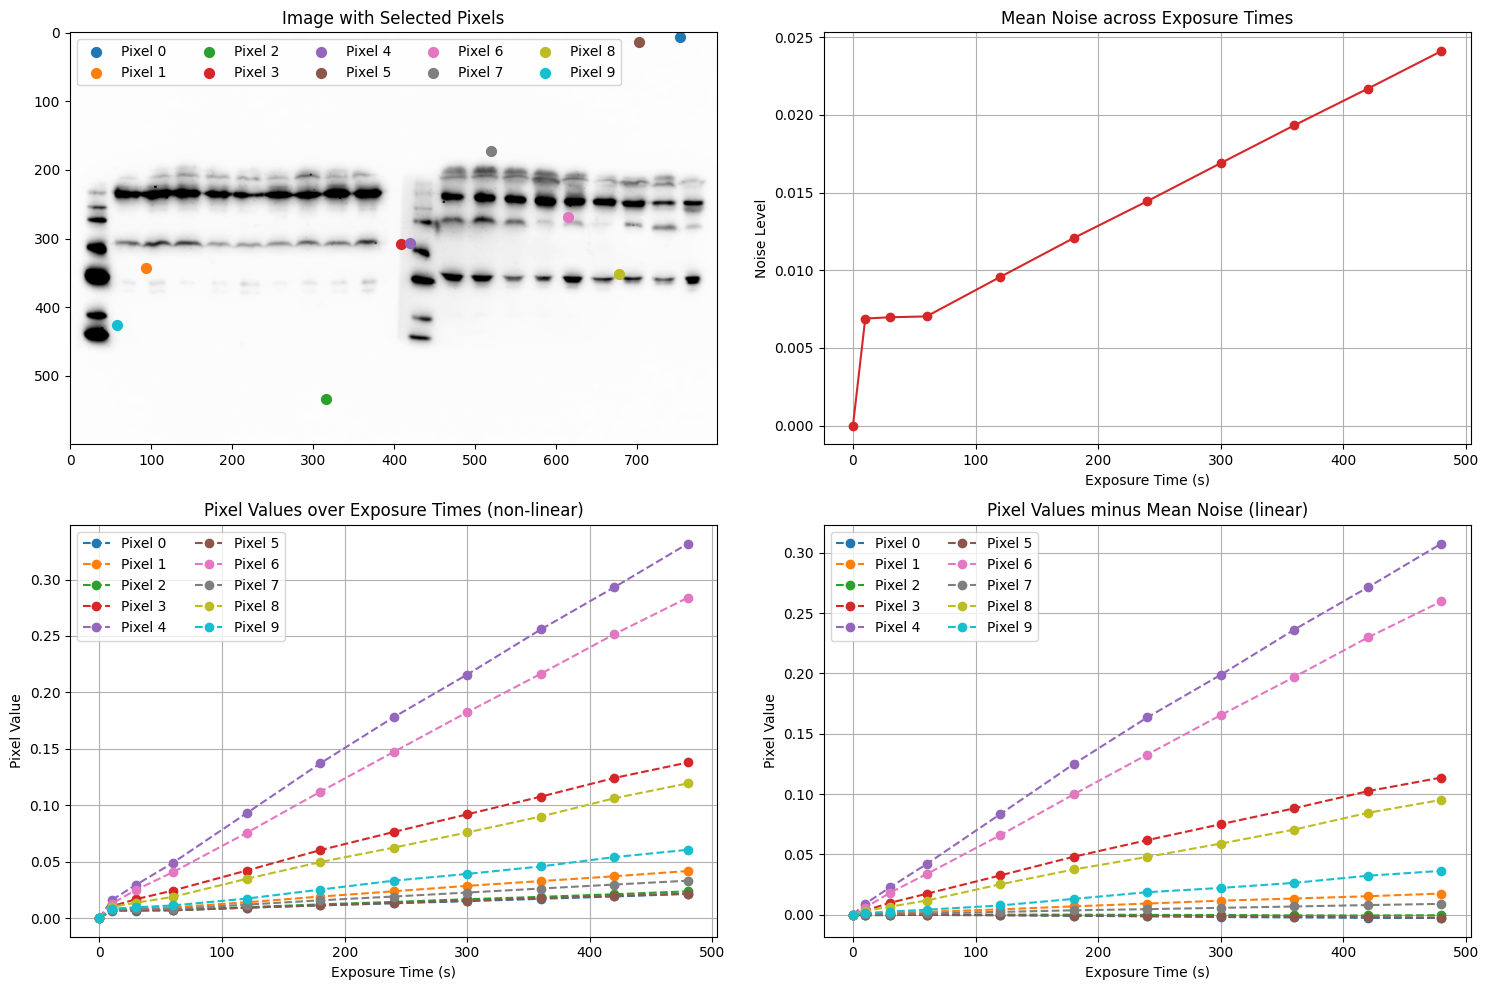

In [13]:
BACKGROUND_THRESHOLD = threshold_slider.value
background_mask, mean_noise = get_background_mean_noise(images_stack, BACKGROUND_THRESHOLD)
plot_image_and_pixel_values(images_stack, exposure_times, mean_noise, n_test_points=10)

In [14]:
intensities = extract_intensities(images_stack, exposure_times, mean_noise)
_ = interact(plot_intensities, idx=IntSlider(min=0, max=intensities.shape[1]-1, step=1, value=30), intensities=fixed(intensities))

interactive(children=(IntSlider(value=30, description='idx', max=799), Output()), _dom_classes=('widget-intera…

In [15]:
# Neural Network
def double_conv(in_channels: int, out_channels: int) -> nn.Sequential:
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class: int) -> None:
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [16]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Model
model = UNet(n_class=1).to(device)
model.load_state_dict(torch.load(f"model_wb_separator_64_7.pth", map_location=torch.device('cpu')))
model.eval()

cpu


UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [17]:
def extract_band(input_crop: np.ndarray, model: nn.Module) -> np.ndarray:
    # Convert the input crop to a tensor
    input_tensor = torch.tensor(input_crop).unsqueeze(0).unsqueeze(0).float()
    # Predict the output mask
    with torch.no_grad():
        output_tensor = model(input_tensor)
    # Convert the output tensor to a numpy array
    output_crop = output_tensor.squeeze().numpy()
    return output_crop

In [18]:
# Store the position of the last click
last_clicked_position = None

all_combinations = list(itertools.product(OPTIONS_1, OPTIONS_2, OPTIONS_3))
results_dict = {combination: 0.0 for combination in all_combinations}

# Convert a specific image from the stack to an IPython Image widget
def get_image_widget(index, images_stack, position=None):
    # plt.close()
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(1 - images_stack[:, :, index], cmap='gray', vmin=0, vmax=1)
    if position:
        # Add a red dot at the clicked position
        ax.scatter(position[0], position[1], s=20, c='red', marker='o')
        ax.vlines(position[0], 0, images_stack.shape[0] - 1, color='red', linestyle='--', linewidth=0.5)
        ax.hlines(position[1], 0, images_stack.shape[1] - 1, color='red', linestyle='--', linewidth=0.5)
    ax.axis('off')  # Hide the axis
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    return Image(value=buf.getvalue(), format='png', width=images_stack.shape[1], height=images_stack.shape[0])

exposure_slider = widgets.IntSlider(value=images_stack.shape[2] // 2, min=0, max=images_stack.shape[2] - 1, description='Exposure:')
display(exposure_slider)

# Initial display
current_index = exposure_slider.value
image_widget = get_image_widget(current_index, images_stack, last_clicked_position)
display(image_widget)

# Handle click events on the image widget
def handle_event(event):
    global current_index, last_clicked_position
    if event['type'] == 'click':
        # Update the last clicked position
        last_clicked_position = (event['offsetX'] - 2, event['offsetY'] - 3)
        new_widget = get_image_widget(current_index, images_stack, last_clicked_position)
        image_widget.value = new_widget.value  # Update the displayed image
        # print(f'Clicked at (x, y): {event["offsetX"]}, {event["offsetY"]}')
        update_crops(last_clicked_position)

event = Event(source=image_widget, watched_events=['click'])
event.on_dom_event(handle_event)

# Update displayed image when slider value changes
def update_image(change):
    global current_index
    current_index = change['new']
    new_widget = get_image_widget(current_index, images_stack, last_clicked_position)
    image_widget.value = new_widget.value

# Attach the update_image function to the slider value
exposure_slider.observe(update_image, names='value')


def get_crops_sections_widget(
    horizontal_index: int,
    vertical_index: int,
    input_image: np.ndarray,
    output_image: np.ndarray,
) -> None:
    # plt.close()
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    max_value = np.max([input_image.max() + np.finfo(float).eps, output_image.max() + np.finfo(float).eps])

    # Input and output images
    axs[0, 0].imshow(1 - input_image / max_value, cmap="gray", vmin=0, vmax=1)
    axs[0, 0].set_title("Input")
    axs[0, 0].vlines(vertical_index, 0, input_image.shape[0] - 1, color="red", linestyle="--")
    axs[0, 0].hlines(horizontal_index, 0, input_image.shape[1] - 1, color="red", linestyle="--")
    axs[0, 0].set_xlim(0, input_image.shape[1] - 1)
    axs[0, 0].set_ylim(input_image.shape[0] - 1, 0)
    axs[1, 1].imshow(1 - output_image / max_value, cmap="gray", vmin=0, vmax=1)
    axs[1, 1].set_title("Output")
    axs[1, 1].vlines(vertical_index, 0, input_image.shape[0] - 1, color="red", linestyle="--")
    axs[1, 1].hlines(horizontal_index, 0, input_image.shape[1] - 1, color="red", linestyle="--")
    axs[1, 1].set_xlim(0, input_image.shape[1] - 1)
    axs[1, 1].set_ylim(input_image.shape[0] - 1, 0)

    # Vertical section
    axs[0, 1].plot(input_image[:, vertical_index], range(input_image.shape[0]), linestyle="--", label="Input")
    axs[0, 1].plot(output_image[:, vertical_index], range(input_image.shape[0]), linestyle="-", label="Output")
    axs[0, 1].set_title("Vertical Section")
    axs[0, 1].set_ylim(0, input_image.shape[0] - 1)
    axs[0, 1].set_xlim(0, max_value)
    axs[0, 1].legend(loc='upper right')

    # Horizontal section
    axs[1, 0].plot(input_image[horizontal_index, :], linestyle="--", label="Input")
    axs[1, 0].plot(output_image[horizontal_index, :], linestyle="-", label="Output")
    axs[1, 0].set_title("Horizontal Section")
    axs[1, 0].set_xlim(0, input_image.shape[1] - 1)
    axs[1, 0].set_ylim(0, max_value)
    axs[1, 0].legend(loc='upper right')

    # plt.tight_layout()

    # Create the widget
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    return Image(value=buf.getvalue(), format='png', width=700, height=700)


# i, j = 310, 146
input_crop = np.zeros((64, 64))
output_crop = np.zeros((64, 64))

# plt.imshow(1 - input_crop, cmap='gray')

# TODO: add horizontal and vertical position sliders

# Create the widget
crops_widget = get_crops_sections_widget(32, 32, input_crop, output_crop)
display(crops_widget)

# Sliders for horizontal and vertical indices
horizontal_slider = IntSlider(min=0, max=input_crop.shape[0] - 1, step=1, value=int(input_crop.shape[0] / 2), description='Horizontal:')
vertical_slider = IntSlider(min=0, max=output_crop.shape[0] - 1, step=1, value=int(output_crop.shape[1] / 2), description='Vertical:')

# Upodate the crops widget when the sliders change
def update_vertical_slider(change):
    new_widget = get_crops_sections_widget(horizontal_slider.value, change['new'], input_crop, output_crop)
    crops_widget.value = new_widget.value

def update_horizontal_slider(change):
    new_widget = get_crops_sections_widget(change['new'], vertical_slider.value, input_crop, output_crop)
    crops_widget.value = new_widget.value

def update_crops(position):
    global i, j
    global input_crop, output_crop
    j, i = position
    input_crop[:, :] = intensities[i-32:i+32, j-32:j+32]
    output_crop[:, :] = extract_band(input_crop, model)
    new_widget = get_crops_sections_widget(horizontal_slider.value, vertical_slider.value, input_crop, output_crop)
    crops_widget.value = new_widget.value

all_combinations = list(itertools.product(OPTIONS_1, OPTIONS_2, OPTIONS_3))
results_dict = {combination: 0.0 for combination in all_combinations}


def save_data_to_excel(results_dict: dict, filename: str) -> None:
    df = pd.DataFrame(results_dict.keys(), columns=['Membrane', 'Lane', 'Protein'])
    df['Value'] = results_dict.values()
    pivot_table = df.pivot_table(index=['Membrane', 'Protein'], columns='Lane', values='Value', fill_value="")
    pivot_table.reindex(OPTIONS_1, level=0).reindex(OPTIONS_2, level=1).reindex(OPTIONS_3, axis=1)
    pivot_table.replace(0.0, None, inplace=True)
    pivot_table.to_excel(filename)


def on_button_clicked(
    results_dict: dict,
    output_crop: np.ndarray,
    selector_box: widgets.VBox,
    filename_textbox: widgets.Text,
) -> callable:
    def on_button_clicked(button):
        combination = tuple([selector.value for selector in selector_box.children])
        print(combination)
        value = output_crop.sum()
        print(value)
        results_dict[combination] = value
        save_data_to_excel(results_dict, filename_textbox.value)

    return on_button_clicked


# display(horizontal_slider)
# display(vertical_slider)

horizontal_slider.observe(update_horizontal_slider, names='value')
vertical_slider.observe(update_vertical_slider, names='value')
sliders_box = widgets.VBox([horizontal_slider, vertical_slider])

# Dropdown selectors for additional options
options_1_selector = widgets.Dropdown(options=OPTIONS_1, description='Membrane:')
options_2_selector = widgets.Dropdown(options=OPTIONS_2, description='Lane:')
options_3_selector = widgets.Dropdown(options=OPTIONS_3, description='Protein:')
selector_box = widgets.VBox([options_1_selector, options_2_selector, options_3_selector])
# Textbox for filename and save button
filename_textbox = widgets.Text(value='wb_results.xlsx', description='File:', layout=widgets.Layout(width='300px'))
button = widgets.Button(
    description="Save",
    layout=widgets.Layout(
        width="212px", height="40px", left="88px", top="10px", border="1px solid black"
    ),
    button_style="success",
)
button.on_click(
    on_button_clicked(
        results_dict, output_crop, selector_box, filename_textbox
    )
)
save_box = widgets.VBox([filename_textbox, button])
# Display widgets
ui = widgets.HBox([sliders_box, selector_box, save_box])

# Display the interactive plot
display(ui)


IntSlider(value=5, description='Exposure:', max=10)

Image(value=b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02h\x00\x00\x01\xce\x08\x06\x00\x00\x00,B\xf5'\x00\…

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03/\x00\x00\x030\x08\x06\x00\x00\x00)\xad_~\x00\x00…

('Membrane 1', 'Lane 1', 'FH')
22.229571118950844
('Membrane 1', 'Lane 1', 'FH')
9.709438405930996
